In [1]:
import sys
sys.path.append('../')

import numpy as np
np.random.seed(314159)

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import parameter_tuning
import plot_boundary
import analysis_functions as af

from metric_functions import compute_accuracy, compute_auc_from_scores
from kernel_SVM_functions import rbf_kernel
from classifiers import QUBOSoftMarginClassifier, SoftMarginKernelClassifier

In [2]:
train_size = 0.4
filename = 'synth_0.4.csv'

run_qsvms = False
run_csvm = False

In [3]:
data = np.loadtxt(f'../synth_data/{filename}', delimiter = ',')

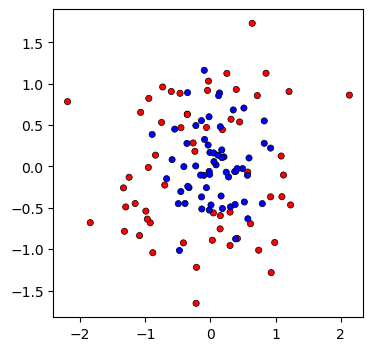

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.scatter(data[:, 0], data[:, 1], c = data[:, 2], cmap = 'bwr', s = 20, edgecolors = 'black', linewidths = 0.5)
plt.show()

In [5]:
X = data[:, :-1]
t = data[:, -1]

X_train, X_test, t_train, t_test = train_test_split(X, t, train_size = train_size, shuffle = True, stratify = t)

t_train = t_train.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)

## QSVMs Calibration

In [6]:
B_values = [2, 3, 5, 10]
K_values = [2, 3, 4]
R_values = [0, 1, 3, 5]
gamma_values = [2 ** i for i in range(-3, 3)]
kernel_func = rbf_kernel
#This results in a matrix with shape (4, 2, 4, 7)

if run_qsvms:

    accuracy_results, auroc_results, times = parameter_tuning.tune_qsvm_parameters(X_train, t_train, B_values, K_values, R_values, gamma_values, kernel_func, num_models = 30)

    np.save(f'../results/QUBO-{filename}-accuracy', accuracy_results)
    np.save(f'../results/QUBO-{filename}-auroc', auroc_results)
    np.save(f'../results/QUBO-{filename}-time', times)


## cSVM Calibration

In [7]:
C_values = [2 ** i for i in range(0, 7)]
gamma_values = [2 **i for i in range(-3, 3)]
kernel_func = rbf_kernel

if run_csvm:

    accuracy_results, auroc_results, times = parameter_tuning.tune_csvm_parameters(X_train, t_train, C_values, gamma_values, kernel_func)

    np.save(f'../results/kSVM-{filename}-accuracy', accuracy_results)
    np.save(f'../results/kSVM-{filename}-auroc', auroc_results)
    np.save(f'../results/kSVM-{filename}-time', times)


## Load data from files

In [8]:
qSVM_accuracy = np.load(f'../results/QUBO-{filename}-accuracy.npy')
qSVM_auroc = np.load(f'../results/QUBO-{filename}-auroc.npy')

cSVM_accuracy = np.load(f'../results/kSVM-{filename}-accuracy.npy')
cSVM_auroc = np.load(f'../results/kSVM-{filename}-auroc.npy')

In [9]:
qSVM_accuracy.shape, cSVM_accuracy.shape

((4, 3, 4, 6), (7, 6))

## Best performance

In [10]:
print(f'cSVM best accuracy {np.max(cSVM_accuracy[:, 1: ])} \n cSVM best auroc {np.max(cSVM_auroc[:, 1: ])} \n')
print(f'qSVM best accuracy {np.max(qSVM_accuracy)} \n qSVM best auroc {np.max(qSVM_auroc)} \n')

cSVM best accuracy 0.82 
 cSVM best auroc 0.9 

qSVM best accuracy 0.7936666666666667 
 qSVM best auroc 0.8572222222222223 



## Best QSVMs models

In [11]:
#Finds the top 20 QSVMs hyper-parameters based on cross validation AUROC score 

val_list = [B_values, K_values, R_values, gamma_values]
model_indices = af.find_best(qSVM_auroc, 20)
top_qsvms_models = [af.get_params(val_list, model_indices[i]) for i in range(len(model_indices))]
qsvm_calib_auc = [qSVM_auroc[i] for i in model_indices]
qsvm_calib_acc = [qSVM_accuracy[i] for i in model_indices]

In [12]:
qsvm_calib_auc[0], qsvm_calib_acc[0]

(0.8572222222222223, 0.7936666666666667)

In [13]:
#New training 50 top models. Keeping the auroc of each model in order to draw a boxplot.
#qsvms top models auroc is shape (50, number of top models). columns represent the results for each model.
qsvm_topmodels_auroc = np.zeros((50, len(top_qsvms_models)))
qsvm_topmodels_acc = np.zeros((50, len(top_qsvms_models)))

kernel_func = rbf_kernel
n = 50

run = False

if run:

    for i, model_parameters in enumerate(top_qsvms_models):
    
        for j in range(n):
        
            qsmc = QUBOSoftMarginClassifier(model_parameters[0], model_parameters[1], model_parameters[2], kernel_func, model_parameters[3])
            qsmc = qsmc.make_QUBO_problem(X_train, t_train).fit(X_train, t_train)
            scores = qsmc.decision_function(X_test)
            preds = qsmc.predict(X_test)
    
            accuracy = compute_accuracy(preds, t_test)
            auroc = compute_auc_from_scores(scores, t_test)
    
            qsvm_topmodels_auroc[j, i] = auroc
            qsvm_topmodels_acc[j, i] = accuracy

    np.save('../results/synth-4_qSVM_top_models', np.array(top_qsvms_models))
    np.save('../results/synth-4_qSVM_top_auroc', qsvm_topmodels_auroc)
    np.save('../results/synth-4_qSVM_top_accuracy', qsvm_topmodels_acc)

top_qsvms_models = np.load('../results/synth-4_qSVM_top_models.npy')
qsvm_topmodels_auroc = np.load('../results/synth-4_qSVM_top_auroc.npy')
qsvm_topmodels_acc = np.load('../results/synth-4_qSVM_top_accuracy.npy')

In [14]:
from scipy.stats import iqr

interquart = iqr(qsvm_topmodels_auroc, axis = 0)
interquart

array([0.04591049, 0.05806327, 0.04938272, 0.0472608 , 0.03549383,
       0.04282407, 0.04224537, 0.04378858, 0.06597222, 0.05767747,
       0.03375772, 0.02893519, 0.04783951, 0.07407407, 0.02565586,
       0.02989969, 0.0464892 , 0.046875  , 0.03684414, 0.0464892 ])

In [15]:
np.mean(interquart, axis=0)

0.04527391975308641

0.5


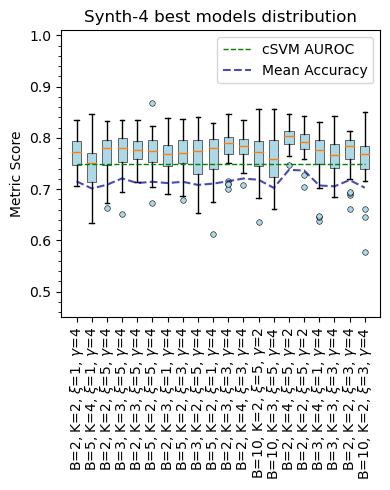

In [16]:
fig, ax = plt.subplots(figsize=(4, 5))

af.models_auc_boxplot(top_qsvms_models, qsvm_topmodels_auroc, 0.75, fig = fig, ax = ax)

ax.plot(np.arange(1, 21, 1), np.mean(qsvm_topmodels_acc, axis=0), linestyle = '--', color='darkblue', alpha = 0.7, zorder = 5, label = 'Mean Accuracy')

ax.set_ylabel('Metric Score')
ax.set_title('Synth-4 best models distribution')

plt.legend()
plt.tight_layout()
plt.savefig('../plots/synth-4-boxplot.png', dpi = 256)
plt.show()

## Best cSVM models

In [17]:
#Finding the 5 cSVM models which performed best in the calibration phase.

val_list = [C_values, gamma_values]
model_indices = af.find_best(cSVM_auroc, 5)
top_csvm_models = [af.get_params(val_list, model_indices[i]) for i in range(len(model_indices))]
csvm_calib_auc = [cSVM_auroc[i] for i in model_indices]
csvm_calib_acc = [cSVM_accuracy[i] for i in model_indices]

In [18]:
csvm_calib_auc

[0.9,
 0.8833333333333334,
 0.8833333333333332,
 0.8666666666666668,
 0.8666666666666666]

In [19]:
#Each of the top 5 csvm models are trained on the full training set and tested on the test set.
#The AUROC and accuracy are the final scores for that dataset.

final_auroc = []
final_accuracy = []

run = False

if run:

    for c, g in top_csvm_models:

        clf = SoftMarginKernelClassifier(c, kernel_func, g)
        clf = clf.fit(X_train, t_train)

        preds = clf.predict(X_test)
        scores = clf.decision_function(X_test)

        final_auroc.append(compute_auc_from_scores(scores, t_test))
        final_accuracy.append(compute_accuracy(preds, t_test))

    np.save('../results/synth-4_cSVM_top_models', top_csvm_models)
    np.save('../results/synth-4_cSVM_top_auroc', np.array(final_auroc))
    np.save('../results/synth-4_cSVM_top_accuracy', np.array(final_accuracy))

top_csvm_models = np.load('../results/synth-4_cSVM_top_models.npy')
final_auroc = np.load('../results/synth-4_cSVM_top_auroc.npy')
final_accuracy = np.load('../results/synth-4_cSVM_top_accuracy.npy')

In [20]:
sort_index = np.argsort(-np.array(final_auroc))

top_csvm_models = np.array(top_csvm_models)[sort_index]
final_auroc = np.array(final_auroc)[sort_index]
final_accuracy = np.array(final_accuracy)[sort_index]

In [21]:
final_auroc, final_accuracy

(array([0.75      , 0.74151235, 0.73302469, 0.73302469, 0.72916667]),
 array([0.65277778, 0.68055556, 0.69444444, 0.69444444, 0.69444444]))

In [22]:
print(top_csvm_models)

[[1 2]
 [1 4]
 [2 2]
 [2 4]
 [4 2]]


## Looking at Bias

In [23]:
QUBOClassifier = QUBOSoftMarginClassifier(2, 4, 5, rbf_kernel, 2)
QUBOClassifier = QUBOClassifier.make_QUBO_problem(X_train, t_train).fit(X_train, t_train)
original_bias = QUBOClassifier.bias.copy()

In [24]:

accuracies = []
b_values = np.arange(-60, 60, 1)
for b in b_values:
    QUBOClassifier = QUBOClassifier.set_bias(b)
    preds = QUBOClassifier.predict(X_test)
    accuracies.append(compute_accuracy(preds, t_test))

In [25]:
from matplotlib.ticker import AutoMinorLocator

In [26]:
original_acc = np.array(accuracies)[np.argmax(b_values > original_bias)]

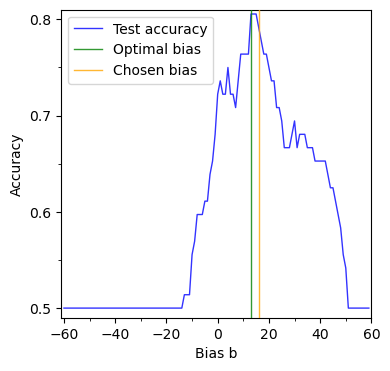

In [27]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(b_values, accuracies, color = 'blue', linestyle='-', label='Test accuracy', alpha=0.8, linewidth=1, zorder=2)

ax.plot([b_values[np.argmax(accuracies)]] * 2, [0.45, 0.9], linewidth=1, color='green', alpha=0.8, zorder=4, label='Optimal bias')
ax.plot([original_bias] * 2, [0.45, 0.9], linewidth=1, color='orange', alpha=0.8, zorder=5, label='Chosen bias')

ax.set_xlim(-61, 60)
ax.set_xticks(np.arange(-60, 61, 20))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))

ax.set_ylim(0.49, 0.81)
ax.set_yticks([0.5, 0.6, 0.7, 0.8], [0.5, 0.6, 0.7, 0.8])
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

ax.set_ylabel('Accuracy')
ax.set_xlabel('Bias b')

ax.legend()

plt.savefig('bias_plot.png', dpi=256)
plt.show()